In [1]:
!git clone https://github.com/iankur/img2tex.git
!curl -L https://ucla.box.com/shared/static/dydrt3sletnhhbmbyydi9ui1twc31wfg.zip --output ICDAR.zip
!mkdir tsr
!mv ICDAR.zip tsr
%cd tsr
!unzip ICDAR.zip
!unzip -q Training_TSR.zip
%cd ..
!mv tsr/train_images img2tex/data
%cd img2tex

Cloning into 'img2tex'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 45 (delta 12), reused 35 (delta 6), pack-reused 0
Unpacking objects: 100% (45/45), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    10    0    10    0     0      6      0 --:--:--  0:00:01 --:--:--     0
100 2718M  100 2718M    0     0  11.4M      0  0:03:58  0:03:58 --:--:-- 11.2M
/content/tsr
Archive:  ICDAR.zip
  inflating: Training_TCR.zip        
  inflating: __MACOSX/._Training_TCR.zip  
  inflating: Validation_TSR.zip      
  inflating: __MACOSX/._Validation_TSR.zip  
  inflating: Validation_TCR.zip      
  inflating: __MACOSX/._Vali

In [2]:
!pip install hydra-core omegaconf pytorch_lightning albumentations wandb pdf2image
!apt-get install -q texlive-latex-base texlive-latex-extra poppler-utils

     |████████████████████████████████| 147 kB 31.1 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
     |████████████████████████████████| 584 kB 61.2 MB/s 
     |████████████████████████████████| 1.8 MB 62.6 MB/s 
     |████████████████████████████████| 112 kB 76.2 MB/s 
     |████████████████████████████████| 596 kB 60.1 MB/s 
     |████████████████████████████████| 409 kB 77.7 MB/s 
     |████████████████████████████████| 136 kB 74.1 MB/s 
     |████████████████████████████████| 1.1 MB 68.1 MB/s 
     |████████████████████████████████| 631 kB 72.2 MB/s 
     |████████████████████████████████| 145 kB 71.3 MB/s 
     |████████████████████████████████| 181 kB 75.7 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 144 kB 73.2 MB/s 
     |████████████████████████████████| 271 kB 71.4 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.

Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd ghostscript fonts-japanese

In [3]:
import os, random, subprocess
from argparse import Namespace
from typing import List, Optional

from IPython.display import Image, HTML
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from omegaconf import DictConfig
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
from pdf2image import convert_from_path

from dataloader import ICDAR21
from dataloader.utils import pil_loader
from pl_models import PlResNetTransformer

GlobalHydra.instance().clear()
initialize(config_path="conf")

hydra.initialize()

In [5]:
# override default values here
config_name = 'tsr_config'
cfg = compose(config_name=config_name, overrides=["trainer.gpus=1", "trainer.max_epochs=4"])

In [6]:
assert os.path.exists(cfg.data.dirname), 'data dir does not exist?'
datamodule = ICDAR21(**cfg.data)
datamodule.setup()

pl_model = PlResNetTransformer(**cfg.pl_model)

callbacks: List[Callback] = []
if cfg.callbacks.model_checkpoint:
    callbacks.append(ModelCheckpoint(**cfg.callbacks.model_checkpoint))
if cfg.callbacks.early_stopping:
    callbacks.append(EarlyStopping(**cfg.callbacks.early_stopping))

logger: Optional[WandbLogger] = None
# if cfg.logger:
#     logger = WandbLogger(**cfg.logger)

trainer = Trainer(**cfg.trainer, callbacks=callbacks, logger=logger)

if trainer.logger:
    trainer.logger.log_hyperparams(Namespace(**cfg))

trainer.tune(pl_model, datamodule=datamodule)
trainer.fit(pl_model, datamodule=datamodule)
trainer.test(pl_model, datamodule=datamodule)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=True)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=True)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNetTransformer  | 3.4 M 
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | val_cer  | CharacterErrorRate | 0     
3 | test_cer | CharacterErrorRate | 0     
4 | val_ser  | SentenceErrorRate  | 0     
5 | test_ser | SentenceErrorRate  | 0     
------------------------------------------------
3.4 M     Trainable params
0

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/cer            0.2392193228006363
        test/ser             0.874333381652832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/cer': 0.2392193228006363, 'test/ser': 0.874333381652832}]

In [29]:
doc = "\documentclass[varwidth=\maxdimen]{standalone}\n\\usepackage{multirow, multicol}\n\\begin{document}\n\\begin{tabular}%s\end{tabular}\n\end{document}"
def show(code):
    if os.path.exists('tmp.pdf'):
        os.remove('tmp.pdf')
    with open('tmp.tex', 'w+') as of:
        of.write(code)
    try:
        subprocess.run(["pdflatex", 'tmp.tex'])
        return convert_from_path('tmp.pdf', fmt='png', size=400)[0]
    except Exception as e:
        return HTML('<img src="something_random.jpg" alt="Incorrect latex code syntax">')

In [30]:
sample_data = random.choice(open(cfg.data.val_file).readlines())
fn, latex = sample_data.split(' ', 1)
fn = os.path.join(cfg.data.dirname, fn)

img = datamodule.transform['val/test'](pil_loader(fn, mode='L'))
img = img.unsqueeze(0)
output = pl_model.model.predict(img)
output = ' '.join(pl_model.tokenizer.decode(output[0].tolist()))

Render ground truth and output latex code blocks

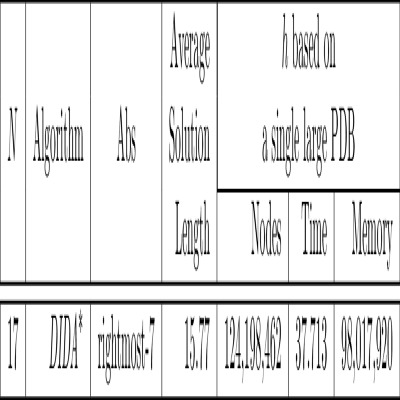

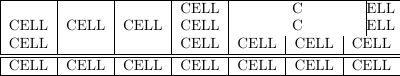

In [31]:
style = "<style>#output-body{display:flex; flex-direction: row;}</style>"
display(HTML(style))

display(Image(filename=fn))
display(show(doc % latex))
display(show(doc % output))

In [32]:
# show aligned output
print('ground truth')
print(latex)
print('output')
print(output)

ground truth
{ | l | r | c | r | r | r | r | } \hline & & & CELL & \multicolumn { 3 } { | c | } CELL \\ CELL & CELL & CELL & CELL & \multicolumn { 3 } { | c | } CELL \\ CELL & & & CELL & CELL & CELL & CELL \\ \hline \hline CELL & CELL & CELL & CELL & CELL & CELL & CELL \\ \hline

output
{ | c | c | c | c | c | c | } \hline & \multicolumn { 3 } { | c | } CELL & \multicolumn { 3 } { | c | } CELL \\ CELL & CELL & CELL & CELL & CELL & CELL \\ \hline CELL & CELL & CELL & CELL & CELL \\ \hline
